In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.decomposition import PCA

In [3]:
NUM_CLASSES = 6

### The networks

#### Transformer

In [22]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim= vocab_size, output_dim= embed_dim)
        self.maxlen = maxlen
        # self.pos_emb = layers.Embedding(input_dim= maxlen, output_dim= embed_dim)

    def get_angles(self, pos, i, embd_dim):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embd_dim))
        return pos * angle_rates

    def positional_encoding(self, max_pos_enc, embd_dim):
        angle_rads = self.get_angles(np.arange(max_pos_enc)[:, np.newaxis],
                                np.arange(embd_dim)[np.newaxis, :],
                                embd_dim)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        # maxlen = tf.shape(x)[-1]
        # print(tf.shape(x)[-1])
        # positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.positional_encoding(max_pos_enc= self.maxlen, embd_dim= self.embed_dim)
        # print(positions.shape)
        # positions = self.pos_encoding(positions)
        x = self.token_emb(x)
        # print(x.shape)
        return x + positions

In [27]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads= num_heads, key_dim= embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [32]:
def create_model_transformer(maxlen = 30121, vocab_size = 259,
                            embed_dim = 50, num_heads = 2, 
                            ff_dim = 16, dout = 0.1, 
                            extra_dense_nodes = 20):
    '''
    embed_dim - Embedding size for each token
    num_heads - Number of attention heads
    ff_dim - Hidden layer size in feed forward network inside transformer
    '''
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dout)(x)
    if extra_dense_nodes!= 0:
        x = layers.Dense(extra_dense_nodes, activation= "relu")(x)
        x = layers.Dropout(dout)(x)
    outputs = layers.Dense(NUM_CLASSES, activation= "softmax")(x)

    model= keras.Model(inputs=inputs, outputs= outputs)
    model.summary()
    model.compile(optimizer= "adam", loss= "sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

In [38]:
model_transformer = create_model_transformer(num_heads= 1)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 30121)]           0         
                                                                 
 token_and_position_embeddin  (None, 30121, 50)        12950     
 g_8 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_8 (Transf  (None, 30121, 50)        12066     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_8   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_33 (Dropout)        (None, 50)                0   

#### LSTM

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

def create_LSTM_model(hidden_unit = 100, embedding_vec = 50)
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, embedding_vec, input_length= maxlen))
    model.add(LSTM(hidden_unit))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30121, 50)         12950     
                                                                 
 lstm_10 (LSTM)              (None, 100)               60400     
                                                                 
 dense_8 (Dense)             (None, 6)                 606       
                                                                 
Total params: 73,956
Trainable params: 73,956
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
lstm_model = create_LSTM_model()

### Kmer

In [8]:
KMER = 3

In [9]:
df_training = pd.read_csv('data/covid/training.csv')
df_training.head(3)

,PID,CLASS,CLASSNAME,SEQ
0,AB257344 |SARS coronavirus Frankfurt 1 genomic...,1,SARS-COV-1,GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTA...
1,AH013708 |SARS coronavirus Sin0409| partial se...,1,SARS-COV-1,CATTCAGTACGGTCGTAGCGGTATAACACTGGGAGTACTCGTGCCA...
2,AH013709 |SARS coronavirus Sin_WNV| partial se...,1,SARS-COV-1,CACGCGCGGGCAAGTCAATGTGCACTCTTTCCGAACAACTTGATTA...


In [10]:
df_training['CLASS'] = df_training['CLASS'].apply(lambda x : x-1)

In [11]:
def kmer_fun(seq, win_size = 3):
    kmer_list = []
    for x in range(len(seq) - win_size + 1):
        kmer_list.append(seq[x:x+win_size].lower())
    return kmer_list

# So let’s try it out with a simple sequence
mySeq = 'CCAGCTGT'
kmer_fun(mySeq, win_size= KMER)

['cca', 'cag', 'agc', 'gct', 'ctg', 'tgt']

In [12]:
df_training['KMER_SEQ'] = df_training['SEQ'].apply(lambda x: kmer_fun(x, KMER))
df_training.head(1)

,PID,CLASS,CLASSNAME,SEQ,KMER_SEQ
0,AB257344 |SARS coronavirus Frankfurt 1 genomic...,0,SARS-COV-1,GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTA...,"[gat, atc, tct, ctc, tct, ctt, ttg, tgt, gta, ..."


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_training['KMER_SEQ'])
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)
print('Found %s unique tokens' % VOCAB_SIZE)

Found 259 unique tokens


In [14]:
df_training['KMER_SEQ_NUM'] = tokenizer.texts_to_sequences(df_training['KMER_SEQ'])
df_training.head(1)

,PID,CLASS,CLASSNAME,SEQ,KMER_SEQ,KMER_SEQ_NUM
0,AB257344 |SARS coronavirus Frankfurt 1 genomic...,0,SARS-COV-1,GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTA...,"[gat, atc, tct, ctc, tct, ctt, ttg, tgt, gta, ...","[32, 45, 22, 50, 22, 11, 3, 5, 41, 47, 17, 32,..."


In [15]:
x_train = df_training['KMER_SEQ_NUM']
maxlen = np.max(df_training['KMER_SEQ_NUM'].str.len())
maxlen

30121

In [16]:
np.max(df_training['SEQ'].str.len())

30123

In [17]:
np.percentile(df_training['KMER_SEQ_NUM'].str.len(), 60)

29644.0

In [18]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = maxlen)
y_train = df_training['CLASS']
x_train.shape, y_train.shape

((1500, 30121), (1500,))

In [19]:
# history = model_lstm.fit(x_train, y_train, epochs=4, batch_size=64)

In [39]:
history = model_transformer.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2


2022-02-20 12:18:50.478567: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB (rounded to 3629098752)requested by op model_8/transformer_block_8/multi_head_attention_8/softmax/Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-02-20 12:18:50.478620: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-02-20 12:18:50.478634: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 270, Chunks in use: 269. 67.5KiB allocated for chunks. 67.2KiB in use in bin. 23.0KiB client-requested in use in bin.
2022-02-20 12:18:50.478642: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 44, Chunks in use: 44. 23.2KiB allocated for chunks. 23.2KiB in use in bin. 17.6KiB 

ResourceExhaustedError:  OOM when allocating tensor with shape[1,1,30121,30121] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_8/transformer_block_8/multi_head_attention_8/softmax/Softmax
 (defined at /home/jlw742/tf/lib/python3.8/site-packages/keras/backend.py:4914)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8879]

Errors may have originated from an input operation.
Input Source operations connected to node model_8/transformer_block_8/multi_head_attention_8/softmax/Softmax:
In[0] model_8/transformer_block_8/multi_head_attention_8/einsum/Einsum (defined at /home/jlw742/tf/lib/python3.8/site-packages/keras/layers/multi_head_attention.py:465)

Operation defined at: (most recent call last)
>>>   File "/home/jlw742/tf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_507380/1289239314.py", line 1, in <module>
>>>     history = model_transformer.fit(x_train, y_train, batch_size=1, epochs=2)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/tmp/ipykernel_507380/1159442329.py", line 14, in call
>>>     attn_output = self.att(inputs, inputs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/layers/multi_head_attention.py", line 503, in call
>>>     attention_output, attention_scores = self._compute_attention(
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/layers/multi_head_attention.py", line 468, in _compute_attention
>>>     attention_scores = self._masked_softmax(attention_scores, attention_mask)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/layers/multi_head_attention.py", line 431, in _masked_softmax
>>>     return self._softmax(attention_scores, attention_mask)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/layers/advanced_activations.py", line 349, in call
>>>     return backend.softmax(inputs, axis=self.axis[0])
>>> 
>>>   File "/home/jlw742/tf/lib/python3.8/site-packages/keras/backend.py", line 4914, in softmax
>>>     return tf.nn.softmax(x, axis=axis)
>>> 

### Ordinal Encoding

In [12]:
def nucleotideToDigit(seq):
    digit_seq = []
    seq = list(seq)
    for n in seq:
        if n == 'T' :
            d = -1.5
        elif n =='C' : 
            d = 0.5
        elif n == 'A' :
            d = 1.5
        elif n == 'G' :
            d = -0.5
        else:
            d = 0
        digit_seq.append(d)
    
    return np.array(digit_seq)
     
nucleotideToDigit('ACTGN')

array([ 1.5,  0.5, -1.5, -0.5,  0. ])

In [13]:
df_training = pd.read_csv('data/covid/training.csv')
df_training.head()

,PID,CLASS,CLASSNAME,SEQ
0,AB257344 |SARS coronavirus Frankfurt 1 genomic...,1,SARS-COV-1,GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTA...
1,AH013708 |SARS coronavirus Sin0409| partial se...,1,SARS-COV-1,CATTCAGTACGGTCGTAGCGGTATAACACTGGGAGTACTCGTGCCA...
2,AH013709 |SARS coronavirus Sin_WNV| partial se...,1,SARS-COV-1,CACGCGCGGGCAAGTCAATGTGCACTCTTTCCGAACAACTTGATTA...
3,AP006557 |SARS coronavirus TWH genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...
4,AP006558 |SARS coronavirus TWJ genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...


In [14]:
df_training['ORDINAL_SEQ'] = df_training['SEQ'].apply(lambda x: nucleotideToDigit(x))
df_training.head()

,PID,CLASS,CLASSNAME,SEQ,ORDINAL_SEQ
0,AB257344 |SARS coronavirus Frankfurt 1 genomic...,1,SARS-COV-1,GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTA...,"[-0.5, 1.5, -1.5, 0.5, -1.5, 0.5, -1.5, -1.5, ..."
1,AH013708 |SARS coronavirus Sin0409| partial se...,1,SARS-COV-1,CATTCAGTACGGTCGTAGCGGTATAACACTGGGAGTACTCGTGCCA...,"[0.5, 1.5, -1.5, -1.5, 0.5, 1.5, -0.5, -1.5, 1..."
2,AH013709 |SARS coronavirus Sin_WNV| partial se...,1,SARS-COV-1,CACGCGCGGGCAAGTCAATGTGCACTCTTTCCGAACAACTTGATTA...,"[0.5, 1.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, -0..."
3,AP006557 |SARS coronavirus TWH genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...,"[1.5, -1.5, 1.5, -1.5, -1.5, 1.5, -0.5, -0.5, ..."
4,AP006558 |SARS coronavirus TWJ genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...,"[1.5, -1.5, 1.5, -1.5, -1.5, 1.5, -0.5, -0.5, ..."


In [15]:
len(df_training.iloc[1]['SEQ']), len(df_training.iloc[1]['ORDINAL_SEQ']), df_training.iloc[1]['PID']

(25665, 25665, 'AH013708 |SARS coronavirus Sin0409| partial sequence')

In [16]:
print('Average length of the seqeunces: ', int(np.mean(df_training['ORDINAL_SEQ'].str.len())))
maxlen = np.max(df_training['ORDINAL_SEQ'].str.len())
maxlen

Average length of the seqeunces:  20151


30123

In [17]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(df_training['ORDINAL_SEQ'], maxlen = maxlen)
x_train.shape, type(x_train)

((1500, 30123), numpy.ndarray)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
x_train_smallerdim = pca.fit_transform(x_train)
x_train_smallerdim.shape

(1500, 200)

In [27]:
y_train = df_training['CLASS']
y_train.shape

(1500,)

In [30]:
# LSTM for sequence classification in the IMDB dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input
from keras.preprocessing import sequence


model = Sequential()
model.add(Input(shape=(x_train_smallerdim.shape[1],1)))
model.add(LSTM(300))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train_smallerdim, y_train, epochs=30, batch_size=64)
# Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 300)               362400    
                                                                 
 dense_6 (Dense)             (None, 6)                 1806      
                                                                 
Total params: 364,206
Trainable params: 364,206
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
24/24 [==============================] - 1s 15ms/step - loss: nan - accuracy: 0.0033
Epoch 2/30
24/24 [==============================] - 0s 13ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/30
24/24 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/30
24/24 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/30
24/24 [=========================

### Test data

In [20]:
df_list = []
test_size = 0

for t in os.listdir('data/covid/test'):
    df = pd.read_csv('data/covid/test/'+t)
    print(t , ' read', ', length: ', len(df))
    print(df.columns)
    test_size += len(df)
    df_list.append(df)
print('Test data size: ', test_size)

test_(2).csv  read , length:  1090
Index(['PID', 'CLASS', 'SEQ'], dtype='object')
test_(3).csv  read , length:  4000
Index(['PID', 'CLASS', 'SEQ'], dtype='object')
test_(5).csv  read , length:  5010
Index(['PID', 'CLASS', 'SEQ'], dtype='object')
test_(4).csv  read , length:  3500
Index(['PID', 'CLASS', 'SEQ'], dtype='object')
test_(1).csv  read , length:  3143
Index(['PID', 'CLASS', 'SEQ'], dtype='object')
Test data size:  16743


In [21]:
merged_test_dfs = pd.concat(df_list)

In [22]:
merged_test_dfs.head(1)

,PID,CLASS,SEQ
0,JF292909 |SARS coronavirus MA15 isolate d2ym4|...,1,CGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGT...


In [23]:
all_data = pd.concat([merged_test_dfs, df_training])
len(all_data)

18243

In [24]:
columns = ['PID', 'CLASS', 'SEQ']
all_data_final = all_data[columns]
print(all_data_final.columns)
all_data_final.head()

Index(['PID', 'CLASS', 'SEQ'], dtype='object')


,PID,CLASS,SEQ
0,JF292909 |SARS coronavirus MA15 isolate d2ym4|...,1,CGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGT...
1,JF292910 |SARS coronavirus MA15 isolate d2ym5|...,1,CGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGT...
2,JF292911 |SARS coronavirus MA15 isolate d4ym1|...,1,CGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGT...
3,JF292912 |SARS coronavirus MA15 isolate d4ym2|...,1,CGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGT...
4,JF292913 |SARS coronavirus MA15 isolate d4ym3|...,1,CGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGT...


In [25]:
all_data_final.dropna()
len(all_data_final)

18243

In [26]:
all_data_final['CLASS'].apply(lambda x: int(x))
all_data_final['SEQ'].apply(lambda x: str.upper(x))
all_data_final.reset_index(inplace=True)

In [27]:
# all_data_final.to_csv('all_data.csv', index=False)

In [28]:
print('Average length of the seqeunces: ', int(np.mean(all_data_final['SEQ'].str.len())))

Average length of the seqeunces:  24861


<AxesSubplot:xlabel='CLASS', ylabel='count'>

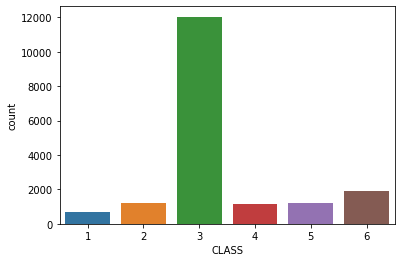

In [29]:
sns.countplot(data= all_data_final, x = 'CLASS')

array([ 1.5,  0.5, -1.5, -0.5,  0. ])

,PID,CLASS,CLASSNAME,SEQ,DIG_SEQ
0,AB257344 |SARS coronavirus Frankfurt 1 genomic...,1,SARS-COV-1,GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTA...,"[-0.5, 1.5, -1.5, 0.5, -1.5, 0.5, -1.5, -1.5, ..."
1,AH013708 |SARS coronavirus Sin0409| partial se...,1,SARS-COV-1,CATTCAGTACGGTCGTAGCGGTATAACACTGGGAGTACTCGTGCCA...,"[0.5, 1.5, -1.5, -1.5, 0.5, 1.5, -0.5, -1.5, 1..."
2,AH013709 |SARS coronavirus Sin_WNV| partial se...,1,SARS-COV-1,CACGCGCGGGCAAGTCAATGTGCACTCTTTCCGAACAACTTGATTA...,"[0.5, 1.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, -0..."
3,AP006557 |SARS coronavirus TWH genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...,"[1.5, -1.5, 1.5, -1.5, -1.5, 1.5, -0.5, -0.5, ..."
4,AP006558 |SARS coronavirus TWJ genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...,"[1.5, -1.5, 1.5, -1.5, -1.5, 1.5, -0.5, -0.5, ..."


In [ ]:
all_data_final

In [46]:
# i = 0
# for row in all_data_final.iterrows():
#     all_data_final['SEQ'][i] = nucleotideToDigit(row[1][3])
#     i+=1

/tmp/ipykernel_272407/3469598069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_final['DIG_SEQ'][i] = nucleotideToDigit(row[1][3])


ValueError: setting an array element with a sequence.

In [36]:
nucleotideToDigit(all_data_final['SEQ'][0])

array([ 0.5, -0.5,  1.5, ...,  1.5, -0.5, -1.5])